In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [3]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/home/derek/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical column and see what happens off of this kind of naive approach.

In [ ]:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [5]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [7]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [9]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,8.49,471.77,64000.0,18.28,0.0,...,0,0,0,0,0,1,0,0,0,0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,12.88,678.49,65000.0,21.77,0.0,...,0,0,0,0,0,1,0,0,0,0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,11.99,400.31,112000.0,8.68,0.0,...,0,0,0,0,0,1,0,0,0,0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,1,0,0,0,0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [9]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=10)
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.9794828 , 0.98048016, 0.98164375, 0.98185747, 0.96509143,
       0.97696509, 0.91503004, 0.98076421, 0.97995583, 0.98043034])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [10]:
# Create cnew df to modify for analysis
df2 = y2015.copy()

Because loan status does have ordinal characteristics (i.e. charged off is worse than in grace period) then coding the variable in an ordinal manner should give us more information than simply converting it to multiple dummy variables

In [11]:
# Change loan status to ordinal categorical to get more accurate correlations

df2['loan_status'].replace({'Charged Off': 0,
                            'Default': 1,
                            'Late (31-120 days)': 2,
                            'Late (16-30 days)': 3,
                            'Current': 3,
                            'Fully Paid': 4,
                            'In Grace Period':5
                           }, inplace=True)

In [28]:
# Get correlations and sort them by strength of correlation with loan status, to help with sorting I will only...
# ... take the absolute values

df2_corrs = abs(df2.corr())
df2_corrs.sort_values(by='loan_status', axis=0, ascending=False, inplace=True)

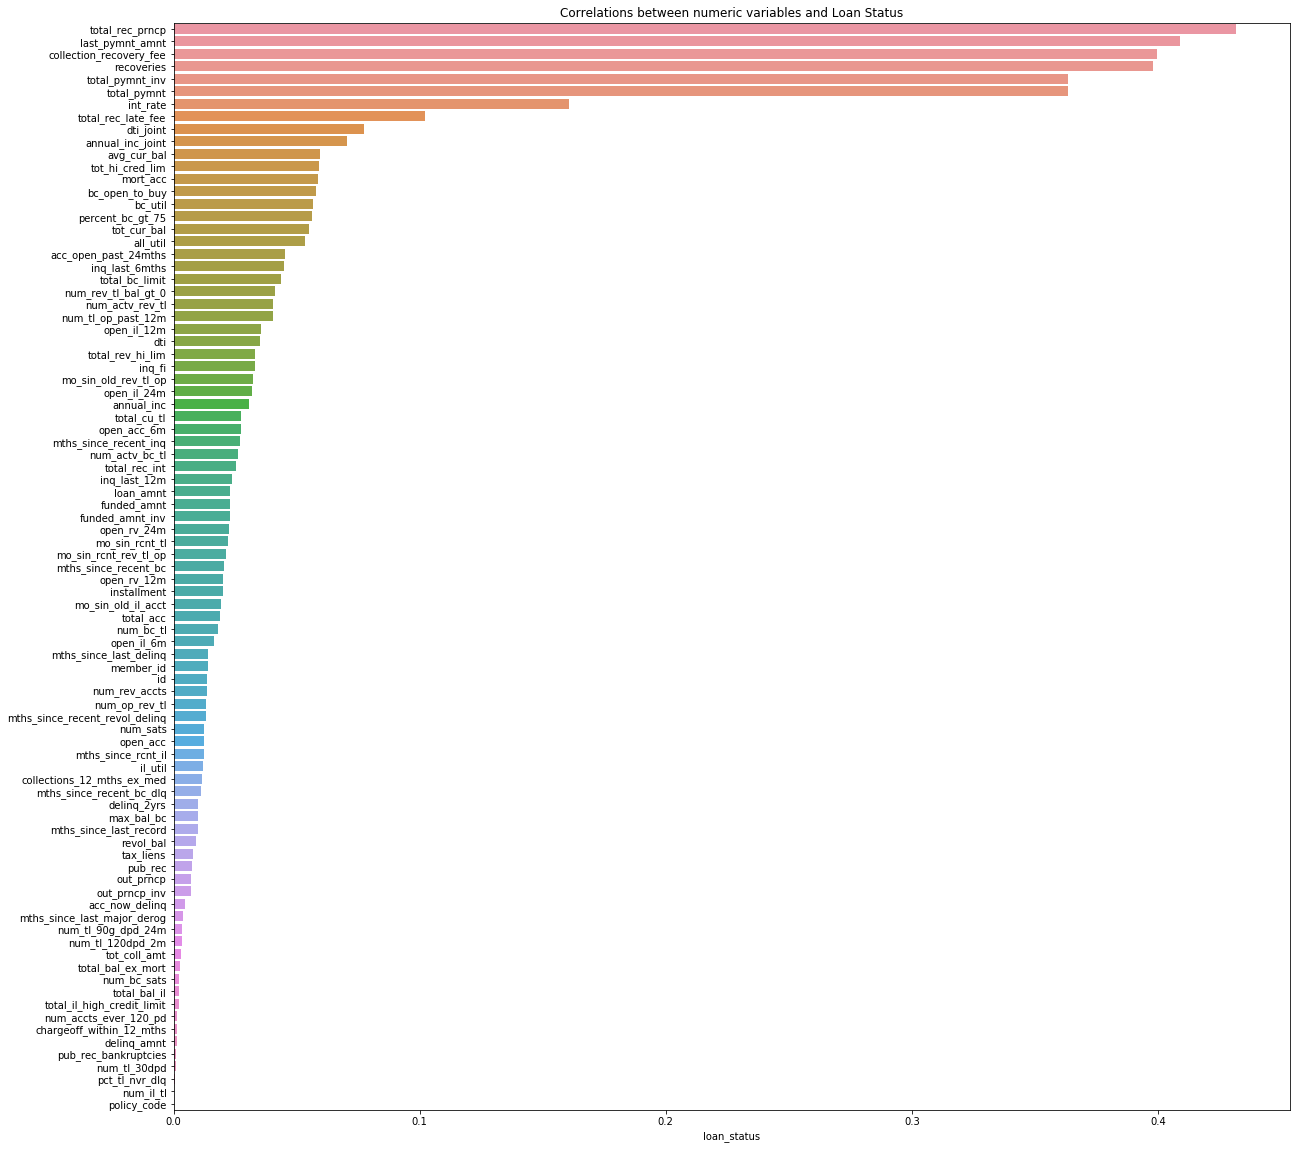

In [29]:
#Because our data is so large, using a heatmap is unrealistc. As a preliminary step I will simply plot the features...
#...that are correlated with loan_status, note that the plot starts at index 1 to avoid 'loan_status'

plt.figure(figsize=(20,20))

sns.barplot(y=df2_corrs.index[1:], x=df2_corrs.iloc[1:,8])
plt.title('Correlations between numeric variables and Loan Status')
plt.show()

Plenty of moderate correlations here to include in the model, there are also many features that have almost no correlation with loan status. We can probably get away with removing the features that have small correlations without sacrificing too much of our model's accuracy. Let's check correlations between loan_status and our dummy categorical variables.

In [14]:
# Get dummy variables for categories

cats = pd.DataFrame(pd.get_dummies(df2.select_dtypes(include=['object'])))
cats['loan_status'] = df2['loan_status']

In [15]:
cat_vars = cats.columns[:-1]

In [16]:
# Get random sample from cats to reduce the load on the kernel

cats_sample = cats.sample(frac=0.2, random_state=1)

In [31]:
# Conduct t-statistics for each dummy variable to measure the magnitude of differences the feature has on loan_status...
# ... take the abs value of these for easier sorting

t = []
for var in cat_vars:
    t.append(abs(stats.ttest_ind(cats_sample.loc[cats_sample[var]==0,'loan_status'],
                                 cats_sample.loc[cats_sample[var]==1,'loan_status'],
                                 equal_var=False)[0]))

In [32]:
cat_plot = pd.DataFrame({'vars':cat_vars,
                        'T-statistic':t})
cat_plot.sort_values(by='T-statistic', axis=0, ascending=False, inplace=True)

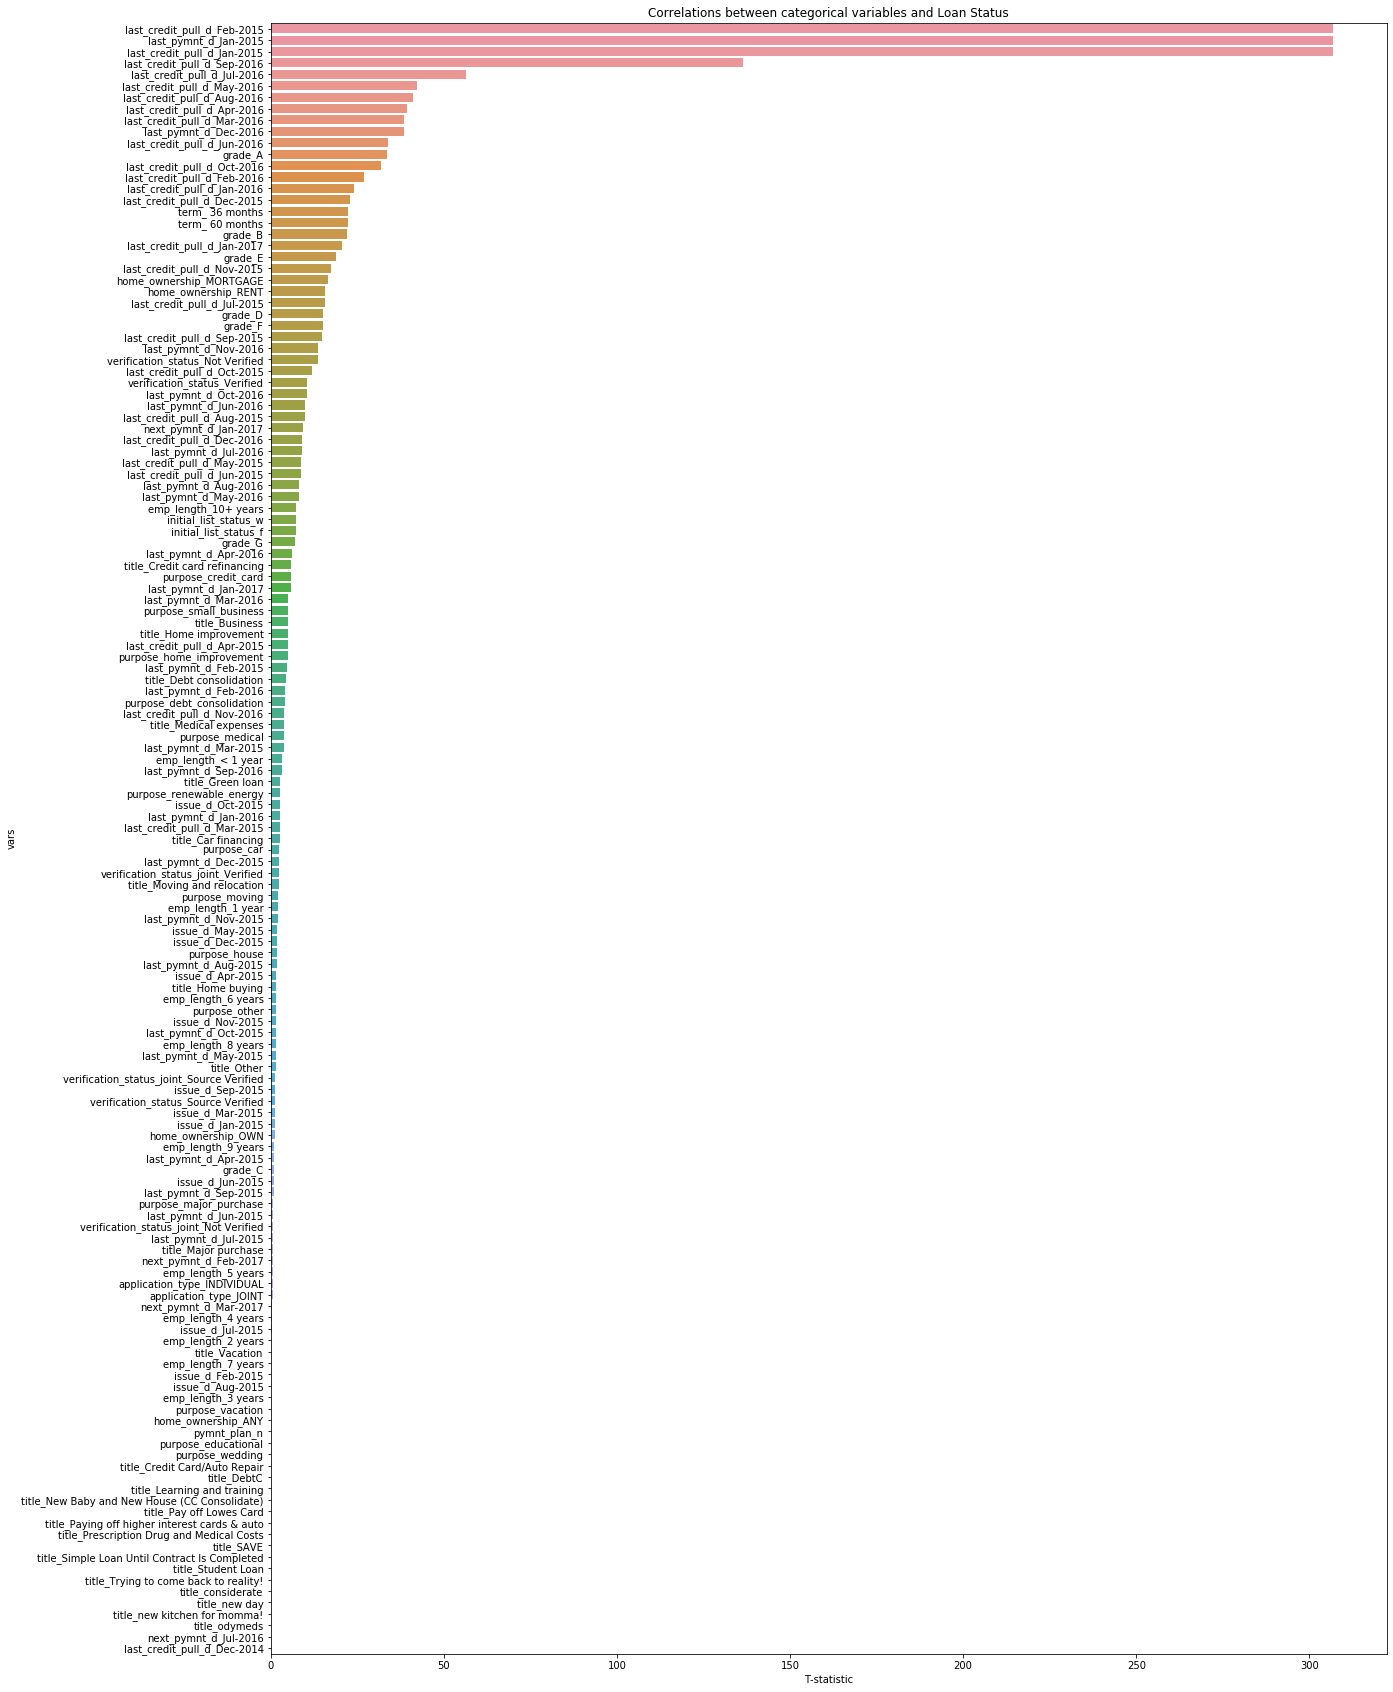

In [34]:
plt.figure(figsize=(20,30))

sns.barplot(y=cat_plot['vars'], x=cat_plot['T-statistic'])
plt.title('Correlations between categorical variables and Loan Status')
plt.show()

The t-tests revealed that there is a very large range in the mean differences among dummy features in the loan_status variable. As a starting point, I will simply take the top 20 numeric and top 20 categorical variables for our model.

# Modeling the Top 20 Numeric and Categorical Features

In [36]:
feature_list = list(cat_plot.loc[:20,'vars'])
feature_list.extend(df2_corrs.index[1:21])

In [43]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
X = df2.drop('loan_status',1)
X = pd.get_dummies(X)
X = X.loc[:,feature_list]
X = X.dropna(axis=1)
Y = df2['loan_status']

cross_val_score(rfc, X, Y, cv=10)

array([0.98330602, 0.98052765, 0.98330563, 0.98211826, 0.97497032,
       0.97753503, 0.96523309, 0.98216533, 0.97646528, 0.98119078])

Well this really cleaned up the accuracy of our model across the 10 cv folds! Our range shrunk from roughly .981 - 0.915 (0.66) to 0.983 - 0.965 (0.18). With the objective of further shrinking our dataset, we likely have some room to work with. Let's shrink the feature set from the top 20 numeric and categorical features to the top 10 and then the top 5. 

# Modeling the Top 10 Numeric and Categorical Features

In [45]:
feature_list = list(cat_plot.loc[:10,'vars'])
feature_list.extend(df2_corrs.index[1:11])

In [46]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
X = df2.drop('loan_status',1)
X = pd.get_dummies(X)
X = X.loc[:,feature_list]
X = X.dropna(axis=1)
Y = df2['loan_status']

cross_val_score(rfc, X, Y, cv=10)

array([0.9574458 , 0.96635083, 0.96820233, 0.96715744, 0.96635004,
       0.96506768, 0.9644969 , 0.96539932, 0.95889142, 0.95554183])

# Modeling the Top 5 Numeric and Categorical Features

In [48]:
feature_list = list(cat_plot.loc[:5,'vars'])
feature_list.extend(df2_corrs.index[1:6])

In [49]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
X = df2.drop('loan_status',1)
X = pd.get_dummies(X)
X = X.loc[:,feature_list]
X = X.dropna(axis=1)
Y = df2['loan_status']

cross_val_score(rfc, X, Y, cv=10)

array([0.80665384, 0.93168056, 0.91892662, 0.92165756, 0.91904536,
       0.91980527, 0.90878435, 0.92414923, 0.93172319, 0.93708885])

Reducing the feature set to only the top 5 numeric and categorical features resulted in 1 cv fold with noticeably poorer performance.

In [52]:
np.mean([0.80665384, 0.93168056, 0.91892662, 0.92165756, 0.91904536, 0.91980527, 0.90878435, 0.92414923, 
 0.93172319, 0.93708885])

0.911951483

Despite the 1 cv fold with low performance, the average value for the cv scores is still greater than 90%.

# Final question
    - Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [88]:
# Find vars that do not contain payment or principal in name

i = df2.columns.str.contains('prncp')
drop_vars = list(df2.columns[i])

i = df2.columns.str.contains('pymnt')
drop_vars.extend(df2.columns[i])

In [94]:
# Drop drop_vars from df

df3 = df2.copy()

df3 = df3.drop(drop_vars,1)

In [112]:
# Get correlations and sort them by strength of correlation with loan status, to help with sorting I will only...
# ... take the absolute values

df3_corrs = abs(df3.corr())
df3_corrs.sort_values(by='loan_status', axis=0, ascending=False, inplace=True)

In [100]:
# Get dummy variables for categories

cats3 = pd.DataFrame(pd.get_dummies(df3.select_dtypes(include=['object'])))
cats3['loan_status'] = df3['loan_status']

cat3_vars = cats3.columns[:-1]

In [102]:
# Get random sample from cats to reduce the load on the kernel

cats3_sample = cats3.sample(frac=0.2, random_state=1)

In [105]:
# Conduct t-statistics for each dummy variable to measure the magnitude of differences the feature has on loan_status...
# ... take the abs value of these for easier sorting

t = []
for var in cat3_vars:
    t.append(abs(stats.ttest_ind(cats3_sample.loc[cats3_sample[var]==0,'loan_status'],
                                 cats3_sample.loc[cats3_sample[var]==1,'loan_status'],
                                 equal_var=False)[0]))

In [106]:
cat3_plot = pd.DataFrame({'vars':cat3_vars,
                        'T-statistic':t})
cat3_plot.sort_values(by='T-statistic', axis=0, ascending=False, inplace=True)

### To give the model a fair chance with the payment and principal data removed I will use the top 10 numeric and categorical variables

In [113]:
feature_list = list(cat3_plot.loc[:10,'vars'])
feature_list.extend(df3_corrs.index[1:11])

In [114]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
X = df3.drop('loan_status',1)
X = pd.get_dummies(X)
X = X.loc[:,feature_list]
X = X.dropna(axis=1)
Y = df3['loan_status']

cross_val_score(rfc, X, Y, cv=10)

array([0.82168555, 0.81166441, 0.81237236, 0.81543576, 0.81325101,
       0.80733792, 0.80358118, 0.80828326, 0.8022941 , 0.69560881])

# Summary

The model performed okay. There is a large range in the cv folds, and the performance is about 10% lower than the previous model which included the top 5 categories. I would say you can create a model without payment or the outstanding principal; however accuracy will be sacrificed and a greater number of features will need to be included to copmensate for the missing information